# Titanic - Machine Learning from Disaster
### Predict survival on the Titanic and get familiar with ML basics

In [82]:
### importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

### importing All models 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

### importing Data preprocessing tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

### importing metrices
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

sns.set(rc = {'figure.figsize':(8,5)})
sns.set_palette('husl')
%matplotlib inline

In [83]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('gender_submission.csv')

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [85]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [86]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [87]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Data cleaning , visualization and EDA

<Axes: xlabel='SibSp', ylabel='Parch'>

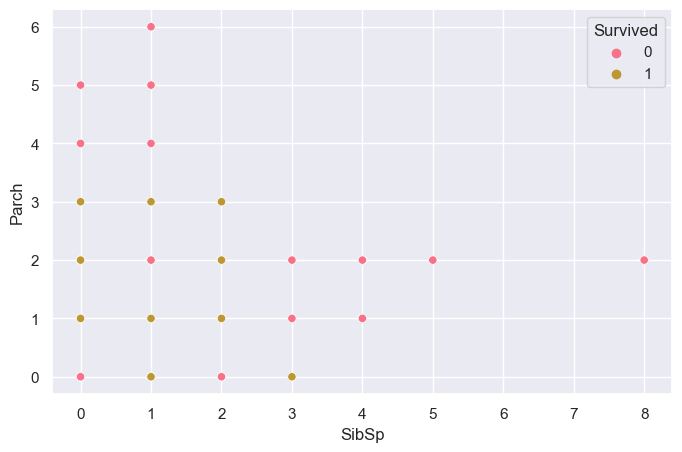

In [88]:
sns.scatterplot(data=train, x='SibSp', y='Parch', hue='Survived')

<Axes: xlabel='Age', ylabel='Density'>

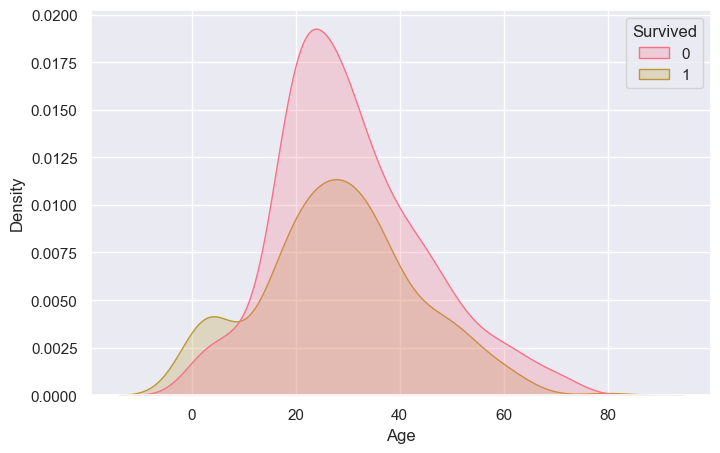

In [89]:
sns.kdeplot(data=train, x='Age', hue='Survived', fill=True)

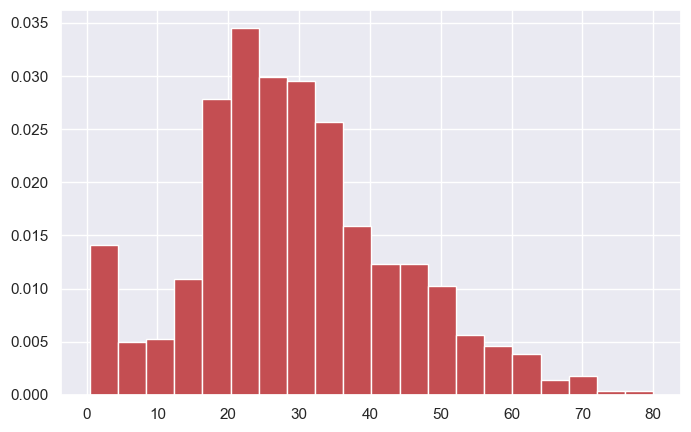

In [90]:
plt.hist(train.Age, density=True, bins=20, color='r')
plt.show()

In [91]:
df = train[(train.Pclass == 1) & ((train.Fare > 80) & (train.Fare < 100)) ]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
224,225,1,1,"Hoyt, Mr. Frederick Maxfield",male,38.0,1,0,19943,90.0000,C93,S
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.0,1,0,36973,83.4750,C83,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


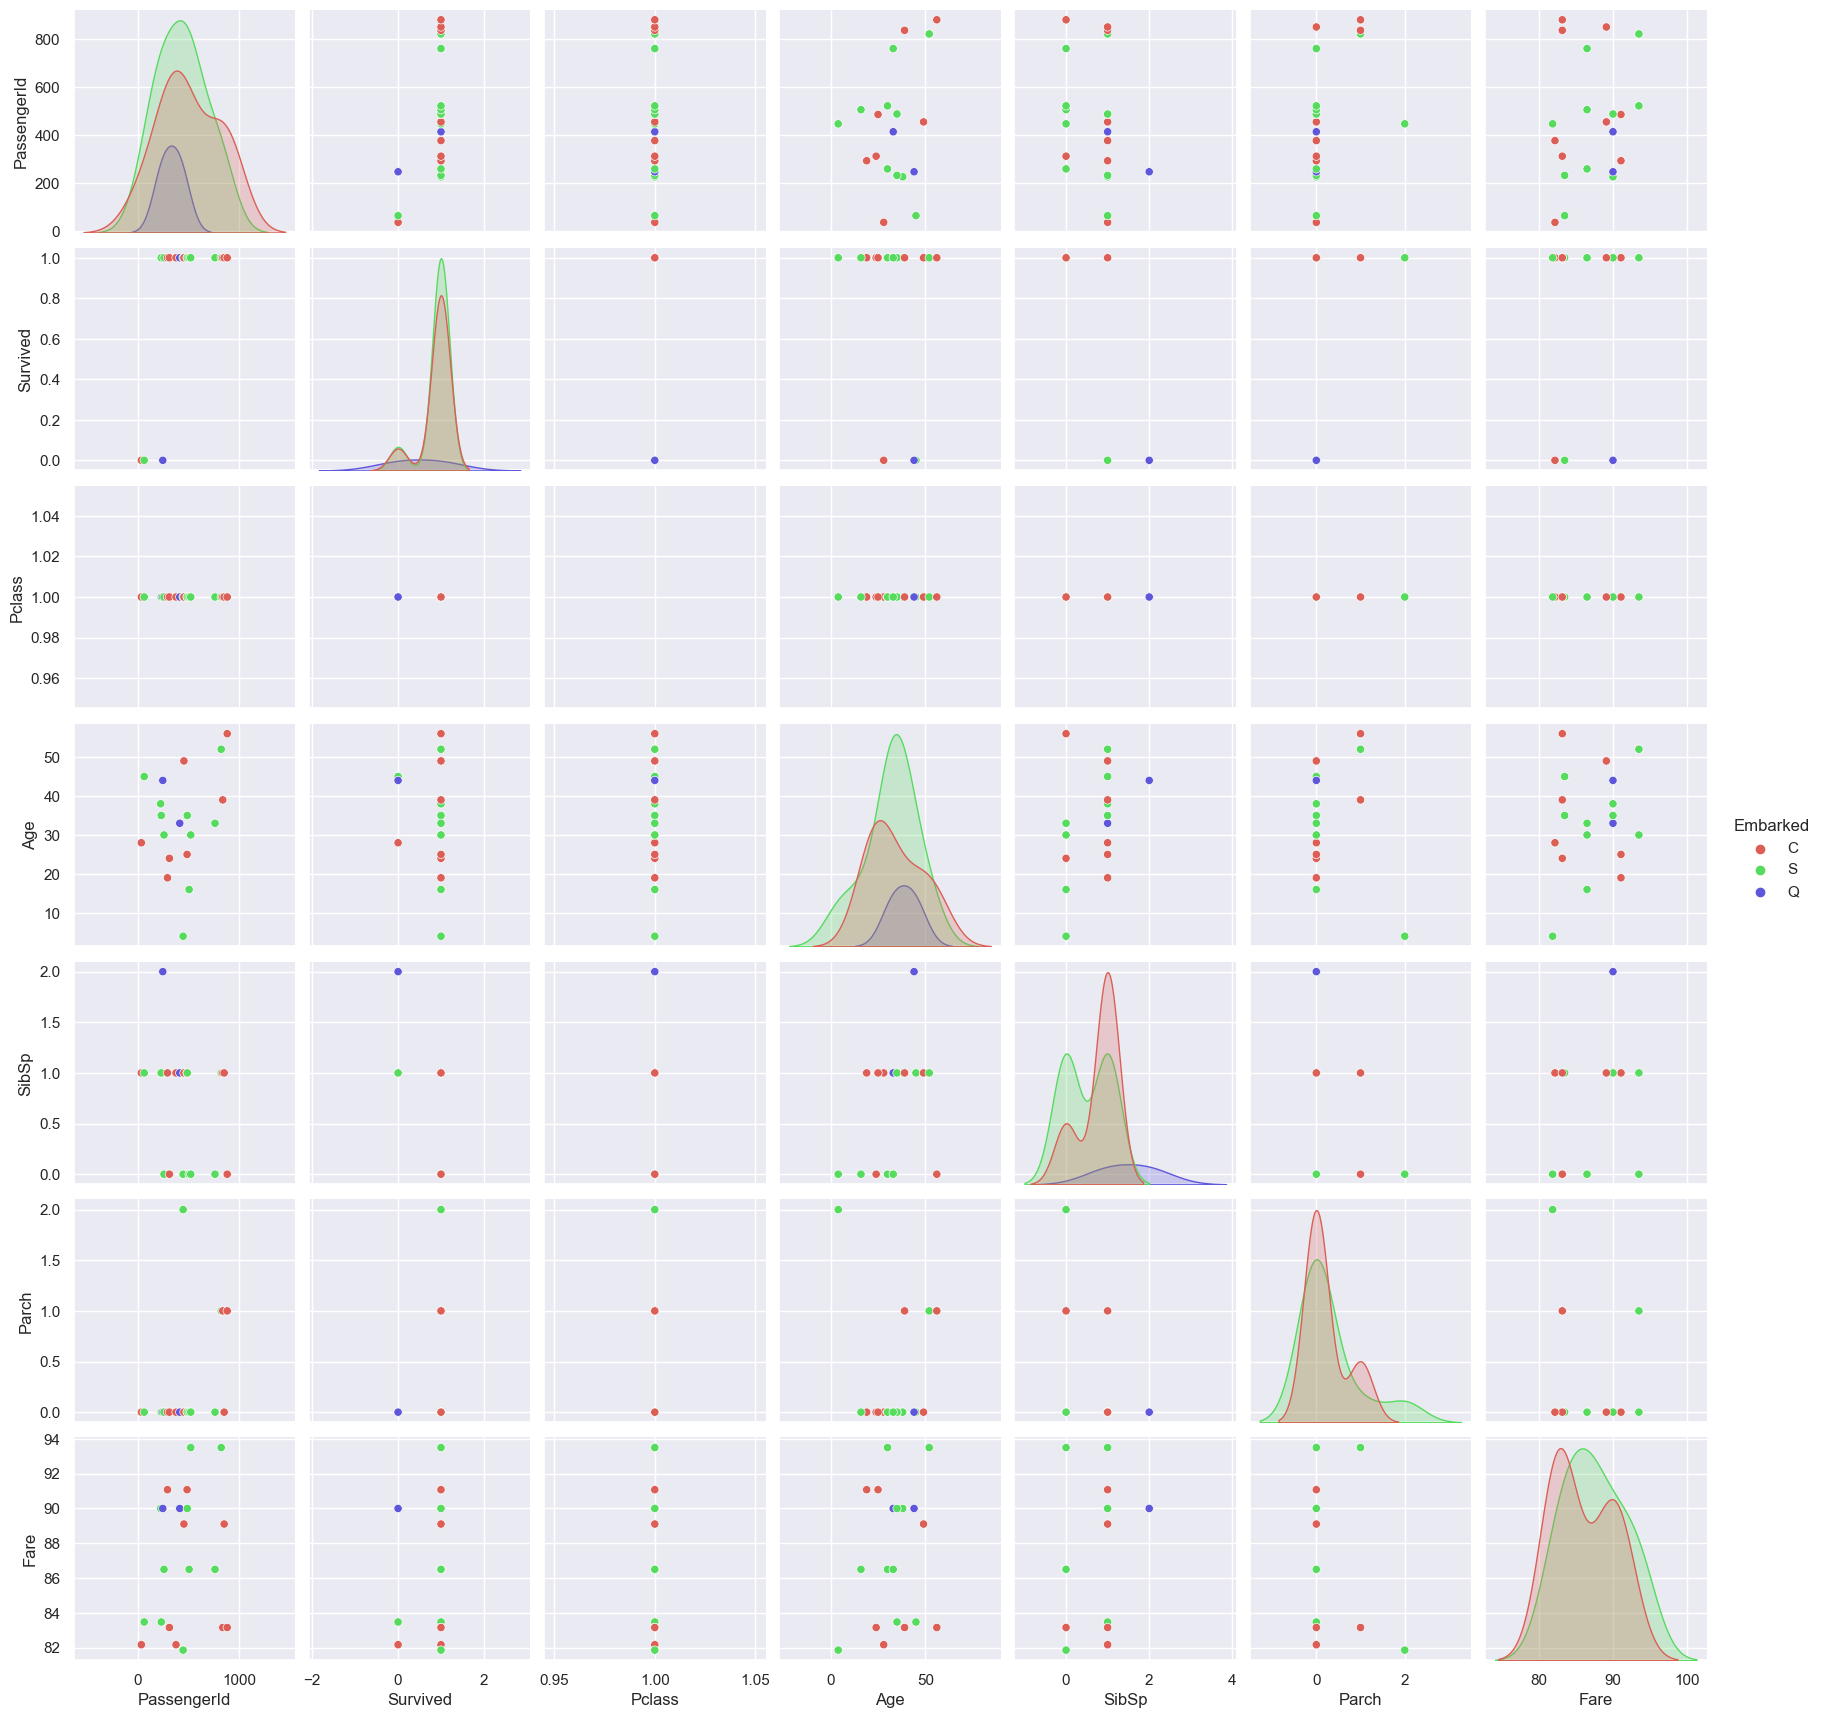

In [92]:
sns.pairplot(data=df, diag_kind='kde', hue='Embarked', palette='hls')

<Axes: xlabel='Fare', ylabel='Survived'>

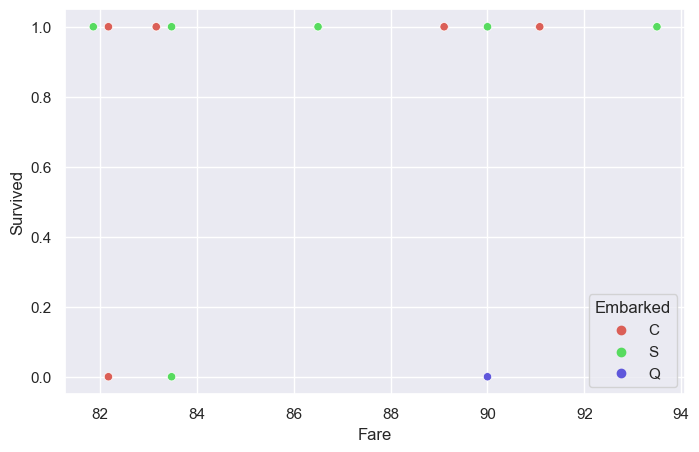

In [93]:
sns.scatterplot(x='Fare', y='Survived', data=df, hue='Embarked', palette='hls')

In [94]:
train.Embarked.fillna('C', inplace=True)

<Axes: xlabel='Pclass', ylabel='count'>

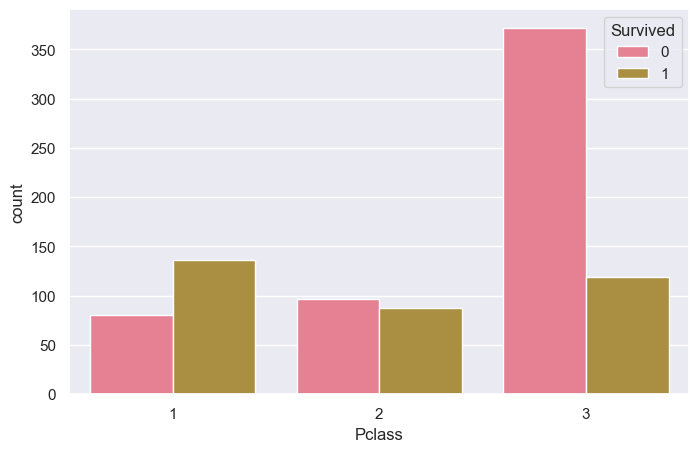

In [95]:
sns.countplot(data=train, x='Pclass', hue='Survived')

<Axes: xlabel='Sex', ylabel='count'>

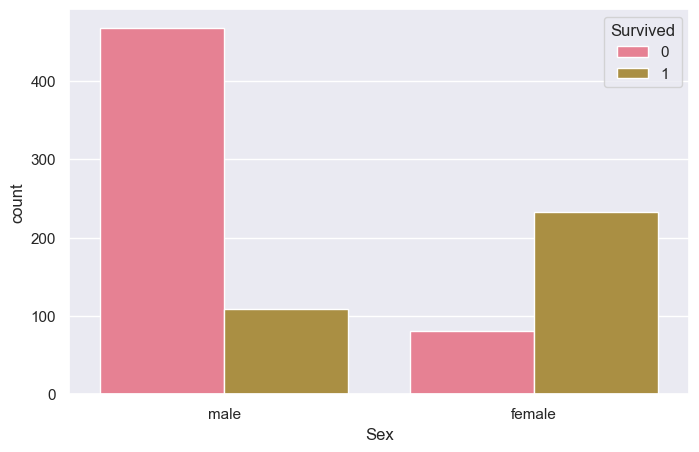

In [96]:
sns.countplot(data=train, x='Sex', hue='Survived')

In [97]:
train.groupby('Pclass', as_index=False).mean()

C:\Users\Nayan\AppData\Local\Temp\ipykernel_16776\997615993.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Pclass,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
1,2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
2,3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [98]:
# assinging Age 
def fill_age(colls):
    Age = colls[0]
    Pclass = colls[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 29
        elif Pclass == 3:
            return 24
    else:
        return Age

In [99]:
train.Age = train[['Age', 'Pclass']].apply(fill_age, axis=1)
test.Age = test[['Age', 'Pclass']].apply(fill_age, axis=1)

In [100]:
test.Fare.fillna(value=test.Fare.mean(), inplace=True)

In [101]:
train['Titels'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Titels'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [102]:
# Most Common Titels
def Title_change(title):
    if title in ['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir','Jonkheer', 'Dona']:
        return 'Others'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Mme':
        return 'Mrs'
    return title

In [103]:
train.Titels = train.Titels.apply(Title_change)
test.Titels = test.Titels.apply(Title_change)

<Axes: xlabel='Titels', ylabel='count'>

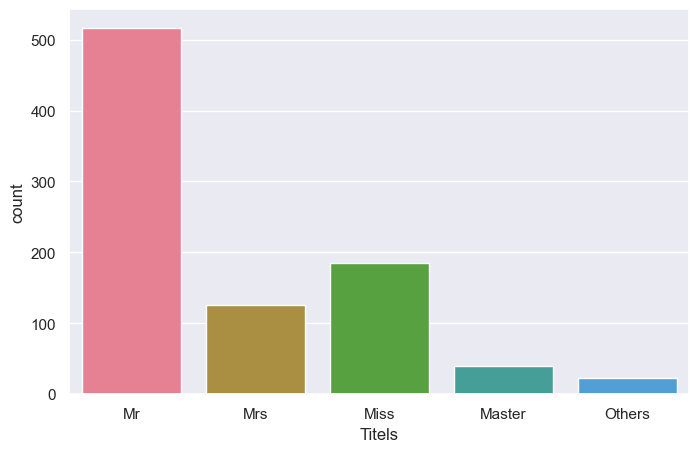

In [104]:
plt.figure(figsize=(8,5))
sns.countplot(train,x='Titels')

In [105]:
def cabin_class(cabin):
    if pd.isnull(cabin):
        return 'No cabin'
    return cabin[0]

In [106]:
train['cabin_status']=train.Cabin.apply(cabin_class)
test['cabin_status']=test.Cabin.apply(cabin_class)

<Axes: xlabel='cabin_status', ylabel='count'>

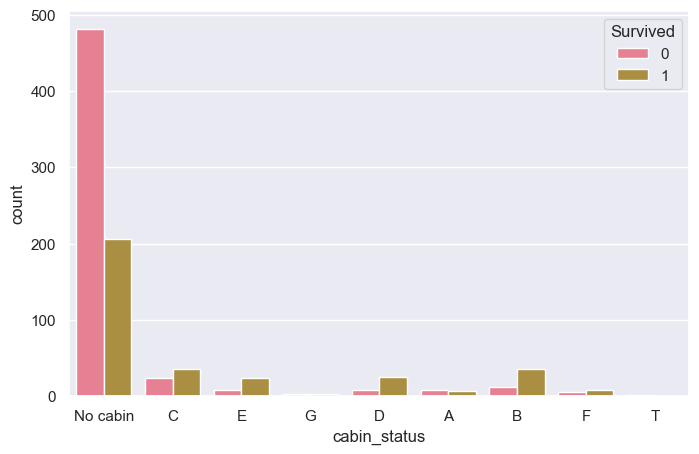

In [107]:
sns.countplot(data=train, x='cabin_status', hue='Survived')

In [108]:
train.drop(train[train.cabin_status == 'T'].index, inplace=True)

In [109]:
train['total_mamber']=train.Parch + train.SibSp
test['total_mamber']=test.Parch + test.SibSp

<Axes: xlabel='total_mamber', ylabel='count'>

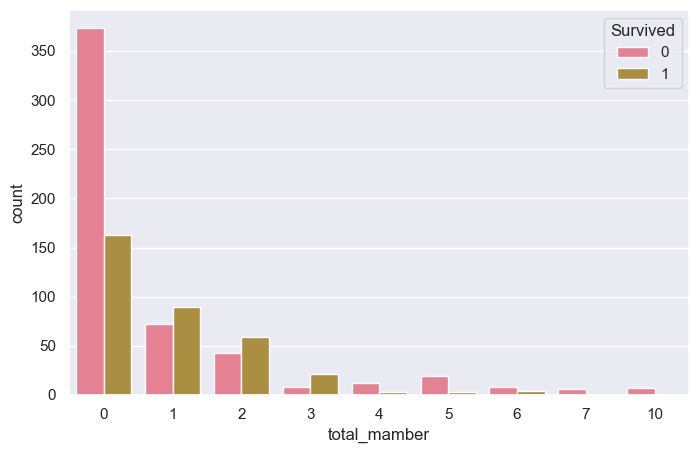

In [110]:
sns.countplot(data=train, x='total_mamber', hue='Survived')

<Axes: xlabel='Fare', ylabel='Density'>

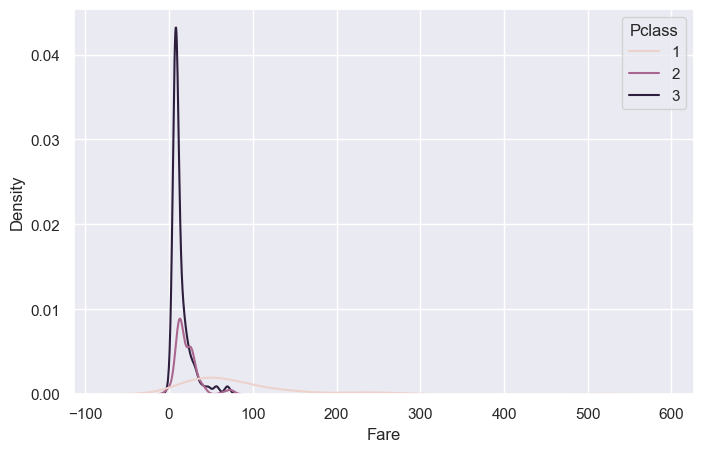

In [111]:
sns.kdeplot(data=train, x='Fare', hue='Pclass')

In [112]:
train['most_common_ticket'] = train.Ticket.apply(lambda x: x.replace('/', '').replace('.', '').split(' ')[0])
test['most_common_ticket'] = test.Ticket.apply(lambda x: x.replace('/', '').replace('.', '').split(' ')[0])

<Axes: >

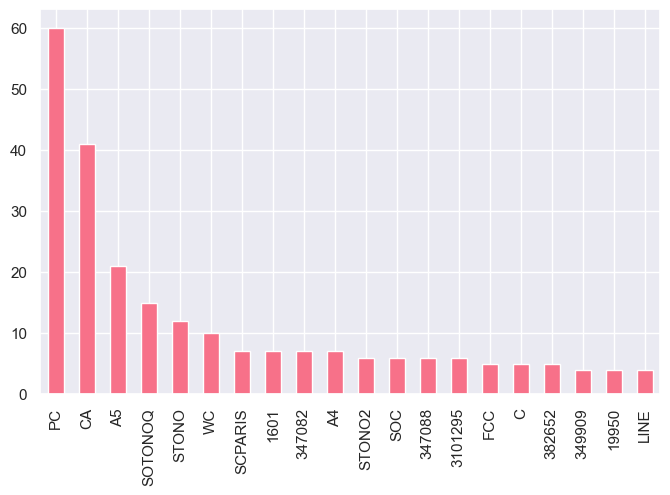

In [113]:
train.most_common_ticket.value_counts().head(20).plot(kind='bar') # 20 most common tickets

In [114]:
most_common_tickets = ['PC', 'CA', 'A5', 'SOTONOQ', 'STONO']

In [115]:
train.most_common_ticket = train.most_common_ticket.apply(lambda item: item if item in most_common_tickets else 'X' )
test.most_common_ticket = test.most_common_ticket.apply(lambda item: item if item in most_common_tickets else 'X' )

<Axes: xlabel='most_common_ticket', ylabel='count'>

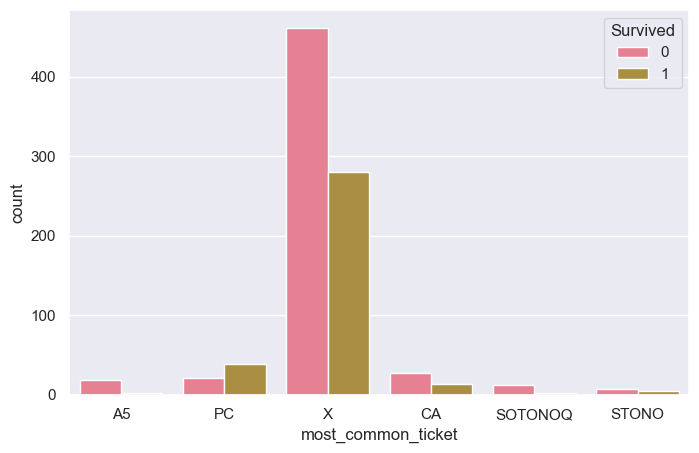

In [116]:
sns.countplot(data=train, x='most_common_ticket', hue='Survived')

<Axes: >

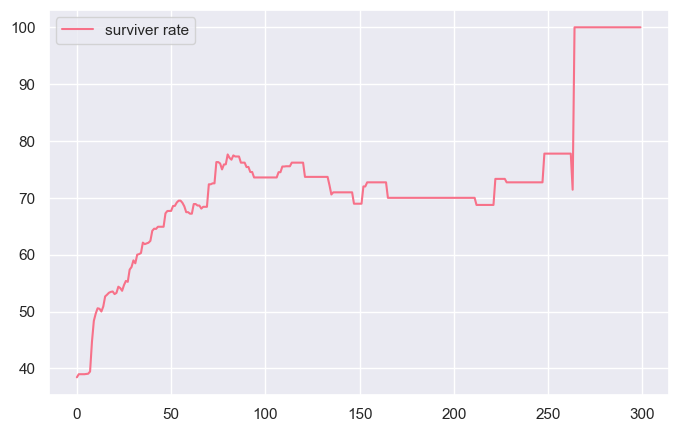

In [117]:
prob = []
d = {}
for i in range(300):
    
    prob.append((train[train.Fare >= i].describe().transpose()['mean'][1])*100)

d = {'surviver rate':prob}   
    
pd.DataFrame(d).plot()

In [118]:
def is_alone(total_mamber):
    
    if total_mamber == 0:
        return 0
    return 1

In [119]:
train['is_alone'] = train.total_mamber.apply(lambda item: 1 if item == 0 else 0)
test['is_alone'] = test.total_mamber.apply(lambda item: 1 if item == 0 else 0)

<Axes: xlabel='SibSp', ylabel='count'>

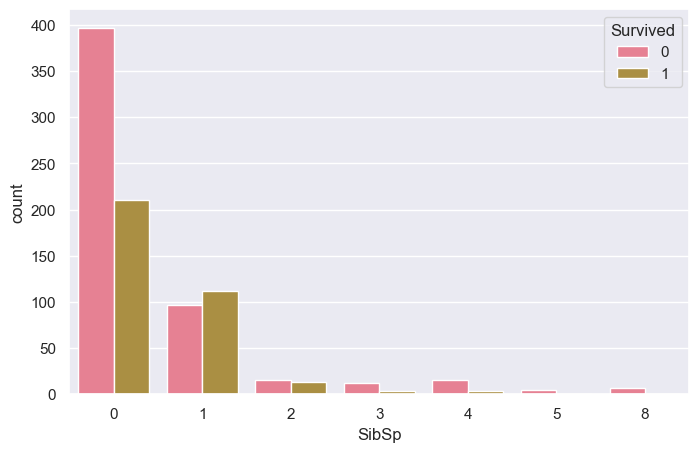

In [120]:
sns.countplot(data=train, x='SibSp', hue='Survived')

In [121]:
train.SibSp = train.SibSp.apply(lambda item: 'more than three' if item >2 else item)

In [122]:
test.SibSp = test.SibSp.apply(lambda item: 'more than three' if item >2 else item)

<Axes: xlabel='Parch', ylabel='count'>

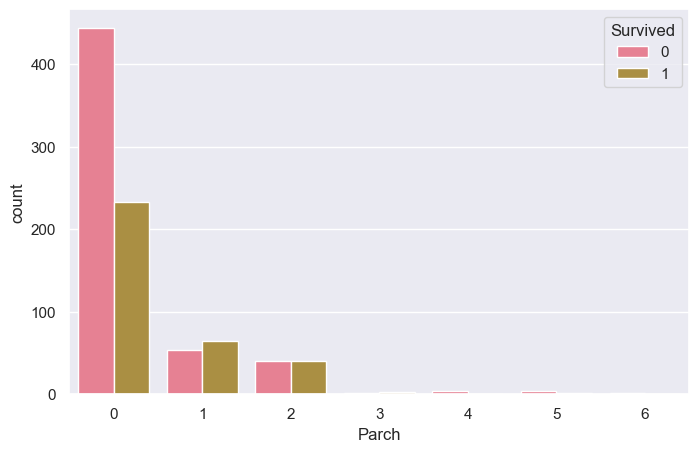

In [123]:
sns.countplot(data=train, x='Parch', hue='Survived')

In [124]:
test.Parch = test.Parch.apply(lambda item: 'more than three' if item >2 else item)
train.Parch = train.Parch.apply(lambda item: 'more than three' if item >2 else item)

In [125]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titels,cabin_status,total_mamber,most_common_ticket,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,No cabin,1,A5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1,PC,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,No cabin,0,X,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1,X,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,No cabin,0,X,1


# Data preprocessing 

In [126]:
X_train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Embarked', 'most_common_ticket', 'total_mamber'], axis=1)
y_train = train.Survived
X_test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked','most_common_ticket', 'total_mamber'], axis=1)
y_test = subm.Survived

In [127]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Titels,cabin_status,is_alone
0,3,male,22.0,1,0,7.2500,Mr,No cabin,0
1,1,female,38.0,1,0,71.2833,Mrs,C,0
2,3,female,26.0,0,0,7.9250,Miss,No cabin,1
3,1,female,35.0,1,0,53.1000,Mrs,C,0
4,3,male,35.0,0,0,8.0500,Mr,No cabin,1
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,Others,No cabin,1
887,1,female,19.0,0,0,30.0000,Miss,B,1
888,3,female,24.0,1,2,23.4500,Miss,No cabin,0
889,1,male,26.0,0,0,30.0000,Mr,C,1


In [128]:
X_train.Pclass = X_train.Pclass.apply(lambda item: str(item))
X_test.Pclass = X_test.Pclass.apply(lambda item: str(item))

In [129]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

<Axes: >

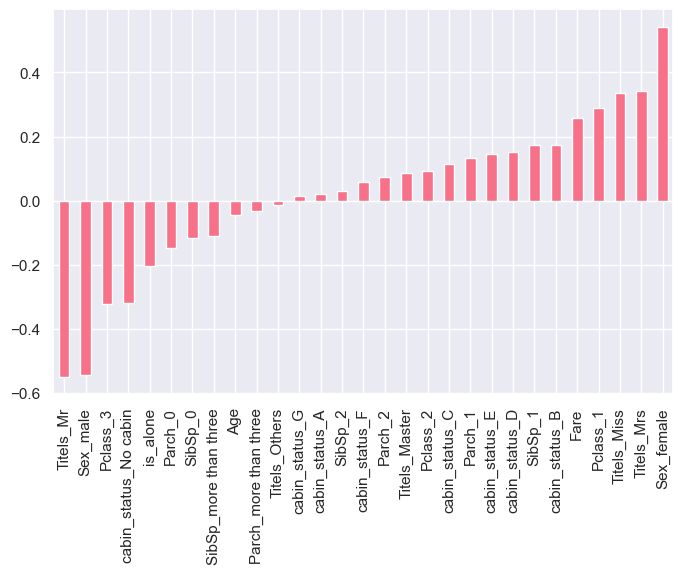

In [130]:
pd.concat([train.Survived, X_train], axis=1).corr().Survived.drop('Survived').sort_values().plot(kind='bar')

# Model Emplementation and Metrics Evaluation

In [131]:
models=[RandomForestClassifier(), AdaBoostClassifier() ,
        GradientBoostingClassifier(), GaussianNB(), XGBClassifier(), LGBMClassifier()]

model_names=['RandomForestClassifier', 'AdaBoostClassifier',
             'GradientBoostingClassifier','GaussianNB', 'XGBClassifier', 'LGBMClassifier']

acc=[]
mean_acc=[]
d={}

for model in range(len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    yprob = clf.predict_proba(X_test)[:, 1]
    acc.append(round(accuracy_score(pred,y_test)*100, 3))
    skf = StratifiedKFold(n_splits=20, shuffle=True)
    mean_acc.append(round(np.mean(cross_val_score(clf,X_train,y_train,cv=skf))*100, 3))
     
d={'Modelling Algo':model_names,'Accuracy':acc, 'mean_Accuracy':mean_acc}


In [132]:
acc_df = pd.DataFrame(d)
acc_df

,Modelling Algo,Accuracy,mean_Accuracy
0,RandomForestClassifier,78.708,81.672
1,AdaBoostClassifier,91.627,81.126
2,GradientBoostingClassifier,88.038,83.139
3,GaussianNB,85.167,78.470
4,XGBClassifier,82.057,81.245
5,LGBMClassifier,83.732,82.389


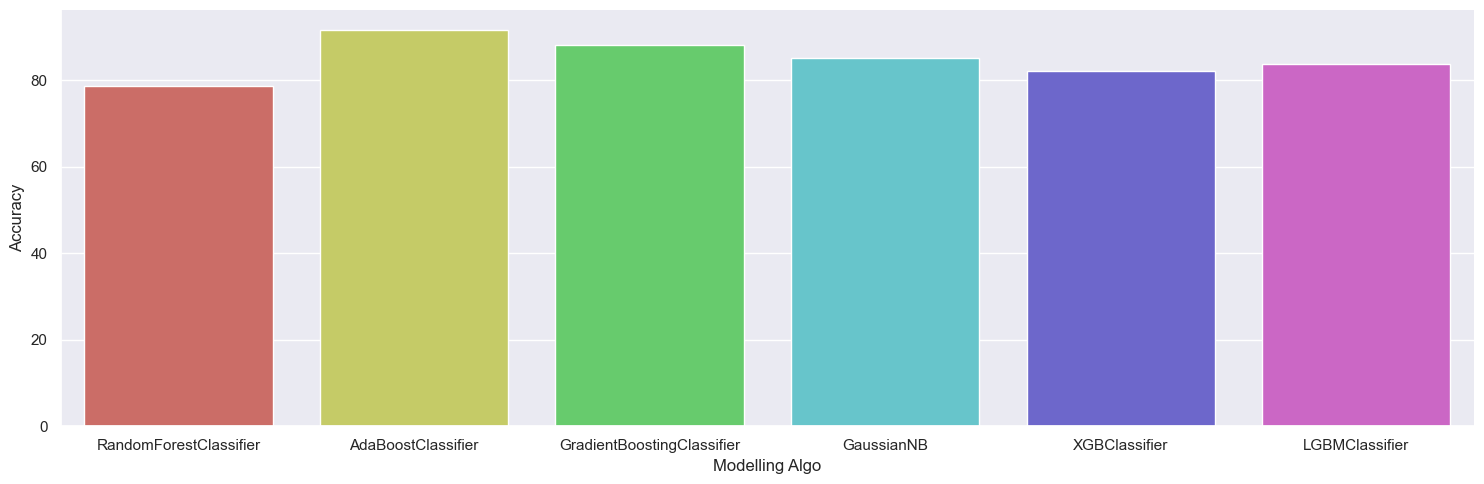

In [133]:
### result comperision
sns.catplot(data=acc_df, x='Modelling Algo', y='Accuracy',kind='bar', height=5,aspect=3, palette='hls')

In [134]:
# xgb is best perfomer
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [135]:
print(f'Testing Accuracy:{accuracy_score(y_test, y_pred)*100:.3f} %')
print(f'Training Accuracy:{accuracy_score(y_train, y_pred_train)*100:.3f} %')
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Testing Accuracy:82.057 %
Training Accuracy:97.079 %


[[224  42]
 [ 33 119]]


              precision    recall  f1-score   support

           0       0.87      0.84      0.86       266
           1       0.74      0.78      0.76       152

    accuracy                           0.82       418
   macro avg       0.81      0.81      0.81       418
weighted avg       0.82      0.82      0.82       418



In [136]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
print(f'mean Accuracy:{np.mean(cross_val_score(RandomForestClassifier(),X_train,y_train,cv=skf))*100:.3f} %')

mean Accuracy:80.339 %


<Axes: >

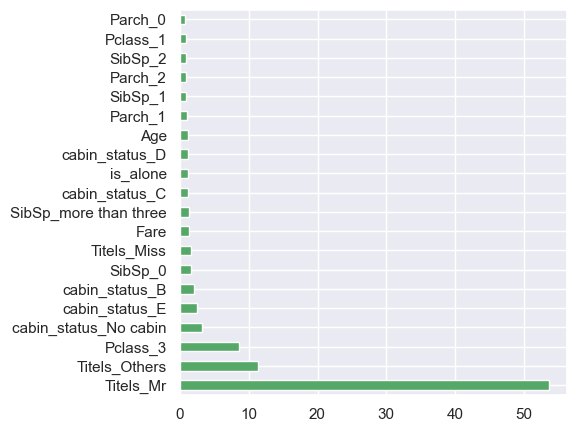

In [137]:
f_imp = pd.Series(clf.feature_importances_*100, index=X_train.columns)
plt.figure(figsize=(5, 5))
f_imp.nlargest(20).plot(kind='barh', color = 'g')

In [138]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

<Axes: >

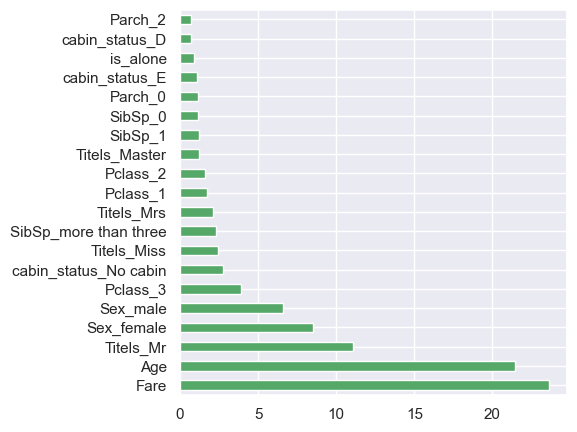

In [139]:
f_imp = pd.Series(model.feature_importances_*100, index=X_train.columns)
plt.figure(figsize=(5, 5))
f_imp.nlargest(20).plot(kind='barh', color = 'g')

In [140]:
print(f'Testing Accuracy:{accuracy_score(y_test, y_pred)*100:.3f} %')
print(f'Training Accuracy:{accuracy_score(y_train, y_pred_train)*100:.3f} %')
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Testing Accuracy:79.904 %
Training Accuracy:98.764 %


[[219  47]
 [ 37 115]]


              precision    recall  f1-score   support

           0       0.86      0.82      0.84       266
           1       0.71      0.76      0.73       152

    accuracy                           0.80       418
   macro avg       0.78      0.79      0.79       418
weighted avg       0.80      0.80      0.80       418



In [141]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


0.8382022471910112

In [142]:
y_pred = RFC_best.predict(X_test)
y_pred_train = RFC_best.predict(X_train)

In [143]:
print(f'Testing Accuracy:{accuracy_score(y_test, y_pred)*100:.3f} %')
print(f'Training Accuracy:{accuracy_score(y_train, y_pred_train)*100:.3f} %')
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Testing Accuracy:84.689 %
Training Accuracy:91.910 %


[[236  30]
 [ 34 118]]


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       266
           1       0.80      0.78      0.79       152

    accuracy                           0.85       418
   macro avg       0.84      0.83      0.83       418
weighted avg       0.85      0.85      0.85       418



<Axes: >

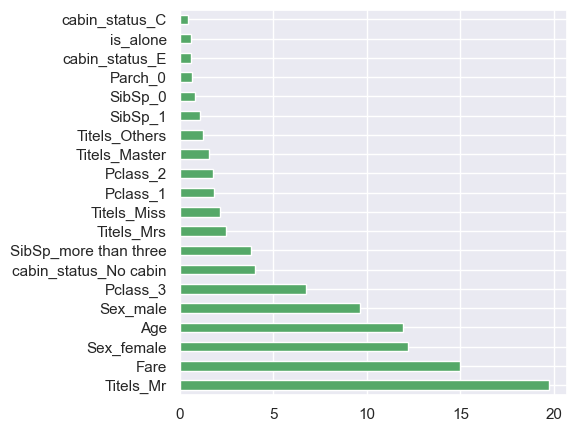

In [144]:
f_imp = pd.Series(RFC_best.feature_importances_*100, index=X_train.columns)
plt.figure(figsize=(5, 5))
f_imp.nlargest(20).plot(kind='barh', color = 'g')

In [145]:
from sklearn.ensemble import VotingClassifier

models=[RandomForestClassifier(), AdaBoostClassifier() ,
        GradientBoostingClassifier(), GaussianNB(), XGBClassifier(), LGBMClassifier()]

model_names=['RandomForestClassifier', 'AdaBoostClassifier',
             'GradientBoostingClassifier','GaussianNB', 'XGBClassifier', 'LGBMClassifier']


model = VotingClassifier(estimators=list(zip(model_names, models)))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [146]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [147]:
print(f'Testing Accuracy:{accuracy_score(y_test, y_pred)*100:.3f} %')
print(f'Training Accuracy:{accuracy_score(y_train, y_pred_train)*100:.3f} %')
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Testing Accuracy:87.321 %
Training Accuracy:93.146 %


[[244  22]
 [ 31 121]]


              precision    recall  f1-score   support

           0       0.89      0.92      0.90       266
           1       0.85      0.80      0.82       152

    accuracy                           0.87       418
   macro avg       0.87      0.86      0.86       418
weighted avg       0.87      0.87      0.87       418



In [148]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
print(f'mean Accuracy:{np.mean(cross_val_score(model,X_train,y_train,cv=skf))*100:.3f} %')

mean Accuracy:82.922 %


In [149]:
XGB = XGBClassifier()
n_estimators = [int(x) for x in np.linspace(start=200, stop=800, num=3)]
max_depth = [int(x) for x in np.linspace(10, 110, num=3)]
max_depth.append(None)
learning_rate=[round(float(x),2) for x in np.linspace(start=0.01, stop=0.2, num=3)]
colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=4)]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'colsample_bytree': colsample_bytree
             }

XGB = GridSearchCV(XGB, param_grid, cv=4, verbose=1)
XGB.fit(X_train, y_train)



Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.1, 0.4, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 60, 110, None],
                         'n_estimators': [200, 500, 800]},
             verbose=1)

In [150]:
model = XGB.best_estimator_

In [151]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

<Axes: >

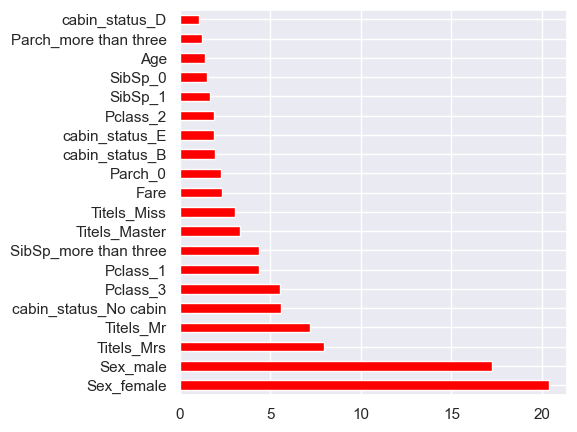

In [152]:
f_imp = pd.Series(model.feature_importances_*100, index=X_train.columns)
plt.figure(figsize=(5, 5))
f_imp.nlargest(20).plot(kind='barh', color = 'red')

In [153]:
print(f'Testing Accuracy:{accuracy_score(y_test, y_pred)*100:.3f} %')
print(f'Training Accuracy:{accuracy_score(y_train, y_pred_train)*100:.3f} %')
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Testing Accuracy:90.670 %
Training Accuracy:90.000 %


[[246  20]
 [ 19 133]]


              precision    recall  f1-score   support

           0       0.93      0.92      0.93       266
           1       0.87      0.88      0.87       152

    accuracy                           0.91       418
   macro avg       0.90      0.90      0.90       418
weighted avg       0.91      0.91      0.91       418



In [154]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1)

models = [XGBClassifier(), XGB.best_estimator_]
model_names = ['XGBClassifier', 'XGBClassifier(tunned)']

data = []
for model in range(len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    yprob = clf.predict_proba(X_test)[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yprob)
    auc_score = roc_auc_score(y_test, yprob)
    name = f"{model_names[model]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=false_positive_rate, y=true_positive_rate, name=name, mode='lines'))
    
    
fig.update_layout(
    title = {'text':'Receiver Operating Characteristic',
             'y':0.9,
             'x':0.4,
             'xanchor': 'center',
             'yanchor': 'top'},
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',)
fig.show()

# Great job!